*Importo librerías.*

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

> Cargo fuente de datos.

In [5]:
df_vh = pd.read_csv(r'D:\Siniestros Viales CABA\Notebooks\Datasets\ETL\victimas_hechos.csv')

In [6]:
#Información
df_vh.shape

(717, 31)

In [7]:
df_vh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     717 non-null    object 
 1   N_VICTIMAS             717 non-null    int64  
 2   FECHA_hechos           717 non-null    object 
 3   AAAA_hechos            717 non-null    int64  
 4   MM_hechos              717 non-null    int64  
 5   DD_hechos              717 non-null    int64  
 6   HORA                   717 non-null    object 
 7   HH                     717 non-null    object 
 8   LUGAR_DEL_HECHO        717 non-null    object 
 9   TIPO_DE_CALLE          717 non-null    object 
 10  Calle                  716 non-null    object 
 11  Altura                 133 non-null    float64
 12  Cruce                  540 non-null    object 
 13  Dirección Normalizada  708 non-null    object 
 14  COMUNA                 717 non-null    int64  
 15  XY (CA

# Investigación sobre datos.

In [8]:
df_vh_faa = df_vh.groupby(['AAAA_hechos']).size().reset_index(name='count')
df_vh_faa.head(6)

,AAAA_hechos,count
0,2016,146
1,2017,140
2,2018,149
3,2019,104
4,2020,81
5,2021,97


In [10]:
df_vh_fmm = df_vh.groupby(['AAAA_hechos', 'MM_hechos']).size().reset_index(name='count')
df_vh_fmm.head(5)

,AAAA_hechos,MM_hechos,count
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7


In [11]:
df_vh_fcs = df_vh.groupby(['COMUNA', 'SEXO']).size().reset_index(name='count')
df_vh_fcs.head(10)

,COMUNA,SEXO,count
0,0,SD,2
1,1,FEMENINO,16
2,1,MASCULINO,76
3,1,SD,1
4,2,FEMENINO,7
5,2,MASCULINO,18
6,3,FEMENINO,14
7,3,MASCULINO,32
8,4,FEMENINO,16
9,4,MASCULINO,61


# Visualización de Datos Geoespaciales.

In [12]:
# ---> Tratamiento de los datos contenidos en las columnas 'pos y' y 'pos x' 
df_vh['pos y'] = pd.to_numeric(df_vh['pos y'], errors='coerce')
df_vh['pos y'] = df_vh['pos y'].replace('.', pd.NA, regex=True)
df_vh['pos x'] = pd.to_numeric(df_vh['pos x'], errors='coerce')
df_vh['pos x'] = df_vh['pos x'].replace('.', pd.NA, regex=True)

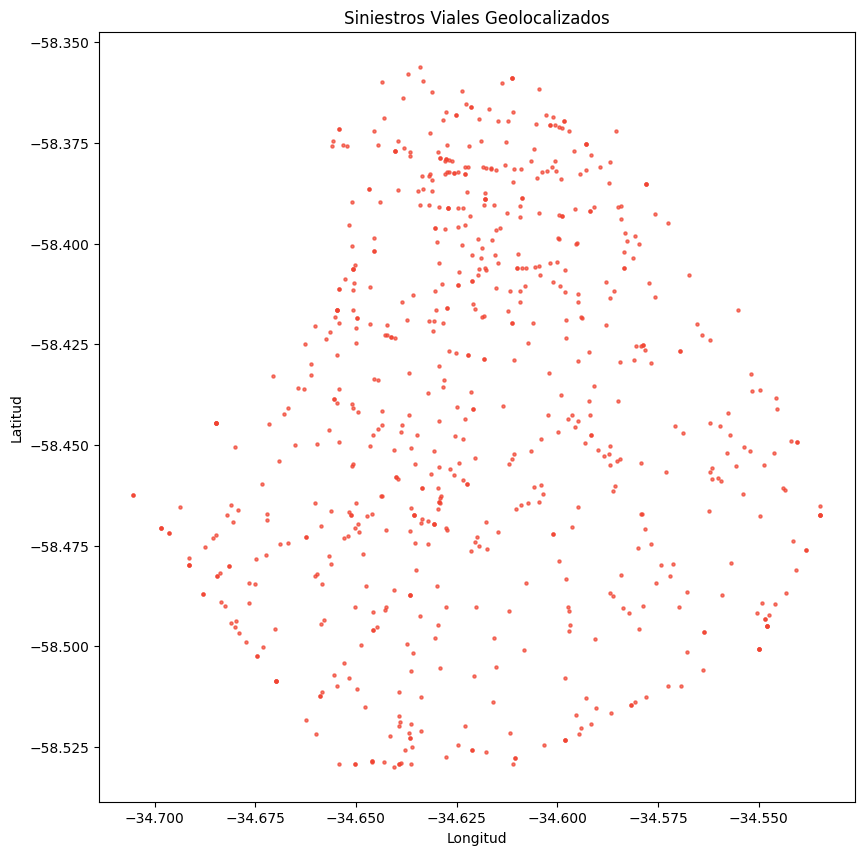

In [14]:
# ---> Creación de la columna 'localizador' para almacenar las coordenadas: 'latitud' (pos y), 'longitud' (pos x)
df_vh['localizador'] = df_vh.apply(lambda row: f"{row['pos y']}, {row['pos x']}", axis=1)

# ---> Conversión de coordenadas a elementos tipo Point
df_vh['geometry'] = df_vh['localizador'].apply(lambda x: Point(map(float, x.split(', '))))
df_vhgeolocalizador = gpd.GeoDataFrame(df_vh, geometry='geometry')

# Mejora visual
cmap = plt.get_cmap('Reds') 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_vhgeolocalizador.plot(ax=ax, color=cmap(0.6), markersize=5, alpha=0.7)
ax.set_title('Siniestros Viales Geolocalizados')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show()

In [16]:
# ---> Cálcula del promedio  de 'pos y' y 'POSX' para localizar geográficamente el mapa
POSY_c = df_vh['pos y'].mean()
POSX_c = df_vh['pos x'].mean()


m = folium.Map(location=[POSY_c, POSX_c], zoom_start=11.5)        # ---> Generación del mapa

# ---> Iteración sobre el DataFrame para definir coordenadas válidas
count = 0
for index, row in df_vh.iterrows():
    coordinates = row['localizador']  
    if pd.notnull(coordinates):
        lat, lon = coordinates.split(', ')
        try:
            lat, lon = float(lat), float(lon)
            folium.Marker(location=[lat, lon]).add_to(m)
        except ValueError:
            count += 1                                          # ---> Conteo del número de coordenadas geoespaciales inválidas
               
print("El número de coordenadas geoespaciales inválidas es --->", count) 
m

El número de coordenadas geoespaciales inválidas es ---> 13


# Filtración para información de interés.

> Se agrupan las columnas de interés según la pontecial oferta de información que tienen:
1. Según su Frecuencia. Ej: fatalidades por unidad de tiempo.
2. Según su carácter demográfico. Ej: fatalidades en función de género y/o edad.
3. Según su localización. Ej: fatalidades en función del lugar de ocurrencia.
4. Según su modo. Ej: fatalidades en función del medio de transporte involucrado.

In [18]:
# ---> Creación de un DataFrame que contenga las columnas de interés, de acuerdo a los criterios previamente señalados
columnas_interes = ['EDAD', 'AAAA_hechos', 'DD_hechos', 'FECHA_FALLECIMIENTO', 'MM_hechos', 'ROL',
                    'SEXO', 'VICTIMA_victimas', 'COMUNA', 'HH', 'LUGAR_DEL_HECHO', 'pos x', 'pos y', 'TIPO_DE_CALLE', 'VICTIMA_hechos']
df_vhf = df_vh.loc[:, columnas_interes]
df_vhf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EDAD                 717 non-null    object 
 1   AAAA_hechos          717 non-null    int64  
 2   DD_hechos            717 non-null    int64  
 3   FECHA_FALLECIMIENTO  717 non-null    object 
 4   MM_hechos            717 non-null    int64  
 5   ROL                  717 non-null    object 
 6   SEXO                 717 non-null    object 
 7   VICTIMA_victimas     717 non-null    object 
 8   COMUNA               717 non-null    int64  
 9   HH                   717 non-null    object 
 10  LUGAR_DEL_HECHO      717 non-null    object 
 11  pos x                704 non-null    float64
 12  pos y                704 non-null    float64
 13  TIPO_DE_CALLE        717 non-null    object 
 14  VICTIMA_hechos       717 non-null    object 
dtypes: float64(2), int64(4), object(9)
memor

In [21]:
#Cambio nombre de columnas para hacerlas más representativas.
df_vhf.rename(columns={'EDAD': 'EDAD_VICTIMA'}, inplace=True)
df_vhf.rename(columns={'AAAA_hechos': 'FECHA_AA'}, inplace=True)
df_vhf.rename(columns={'DD_hechos': 'FECHA_DD'}, inplace=True)
df_vhf.rename(columns={'MM_hechos': 'FECHA_MM'}, inplace=True)
df_vhf.rename(columns={'ROL': 'ROL_VICTIMA'}, inplace=True)
df_vhf.rename(columns={'SEXO': 'SEXO_VICTIMA'}, inplace=True)
df_vhf.rename(columns={'VICTIMA_victimas': 'VH_VICTIMA'}, inplace=True)
df_vhf.rename(columns={'VICTIMA_hechos': 'VH_ACUSADO'}, inplace=True)

In [23]:
# ---> Reemplazar valores 'SD' y 'Sin Dato' por '0' en columna 'EDAD_VICTIMA' 
df_vhf['EDAD_VICTIMA'] = df_vhf['EDAD_VICTIMA'].replace('SD', '0')
df_vhf['HH'] = df_vhf['HH'].replace('SIN DATO', '0')

# ---> Conversión de columnas 'EDAD_VICTIMA' y 'HH' de tipo str a int
df_vhf['EDAD_VICTIMA'] = df_vhf['EDAD_VICTIMA'].astype('int64')
df_vhf['HH'] = pd.to_numeric(df_vhf['HH'], errors='coerce').fillna(0).astype('int64')

# Tratamiento de valores nulos.

In [24]:
df_vhf.duplicated().sum()                        # ---> Número de filas duplicadas

0

In [25]:
print(df_vhf.isna().sum())                      # ---> Número de campos Nulos

EDAD_VICTIMA            0
FECHA_AA                0
FECHA_DD                0
FECHA_FALLECIMIENTO     0
FECHA_MM                0
ROL_VICTIMA             0
SEXO_VICTIMA            0
VH_VICTIMA              0
COMUNA                  0
HH                      0
LUGAR_DEL_HECHO         0
pos x                  13
pos y                  13
TIPO_DE_CALLE           0
VH_ACUSADO              0
dtype: int64


In [27]:
# ---> Conversión de valores nulos al número cero '0' en columnas 'POSY' y 'POSX'
df_vhf['pos y'] = df_vhf['pos y'].fillna(0)
df_vhf['pos x'] = df_vhf['pos x'].fillna(0)
df_vhf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EDAD_VICTIMA         717 non-null    int64  
 1   FECHA_AA             717 non-null    int64  
 2   FECHA_DD             717 non-null    int64  
 3   FECHA_FALLECIMIENTO  717 non-null    object 
 4   FECHA_MM             717 non-null    int64  
 5   ROL_VICTIMA          717 non-null    object 
 6   SEXO_VICTIMA         717 non-null    object 
 7   VH_VICTIMA           717 non-null    object 
 8   COMUNA               717 non-null    int64  
 9   HH                   717 non-null    int64  
 10  LUGAR_DEL_HECHO      717 non-null    object 
 11  pos x                717 non-null    float64
 12  pos y                717 non-null    float64
 13  TIPO_DE_CALLE        717 non-null    object 
 14  VH_ACUSADO           717 non-null    object 
dtypes: float64(2), int64(6), object(7)
memor

# Outliers.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\4145778949.py:6: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)


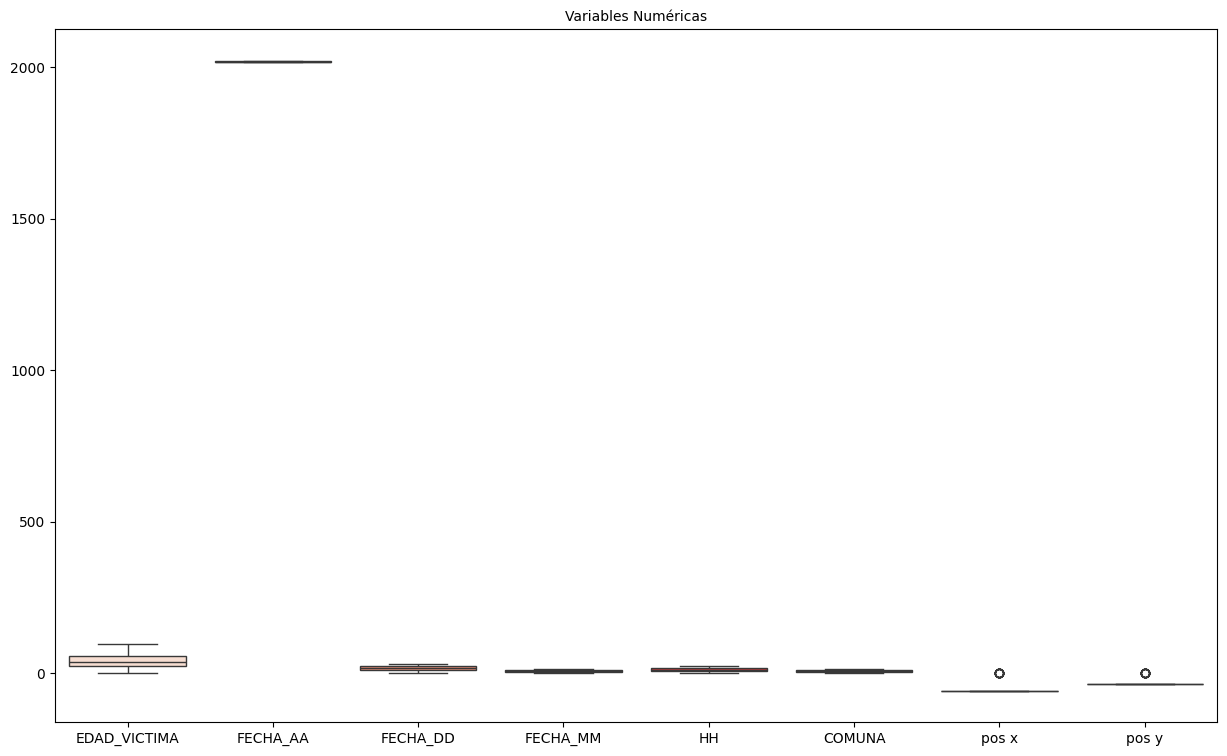

In [30]:
num_cols = ['EDAD_VICTIMA', 'FECHA_AA', 'FECHA_DD', 'FECHA_MM', 'HH', 'COMUNA', 'pos x', 'pos y']

paleta_siniestros = sns.color_palette("Reds")  #Nos servirá para mantener uniformidad en los colores

plt.figure(figsize=(15,9))
sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)
plt.title("Variables Numéricas", fontsize=10)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\2103630780.py:4: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)


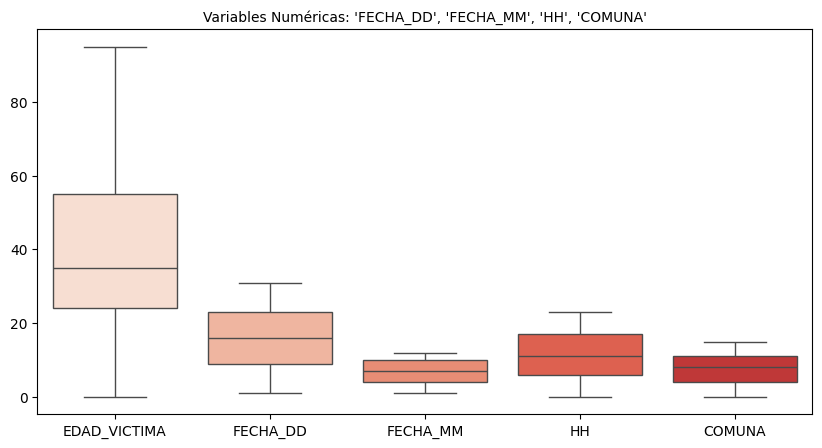

In [31]:
num_cols = ['EDAD_VICTIMA', 'FECHA_DD', 'FECHA_MM', 'HH', 'COMUNA']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)
plt.title("Variables Numéricas: 'FECHA_DD', 'FECHA_MM', 'HH', 'COMUNA'", fontsize=10)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\2919097924.py:4: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)


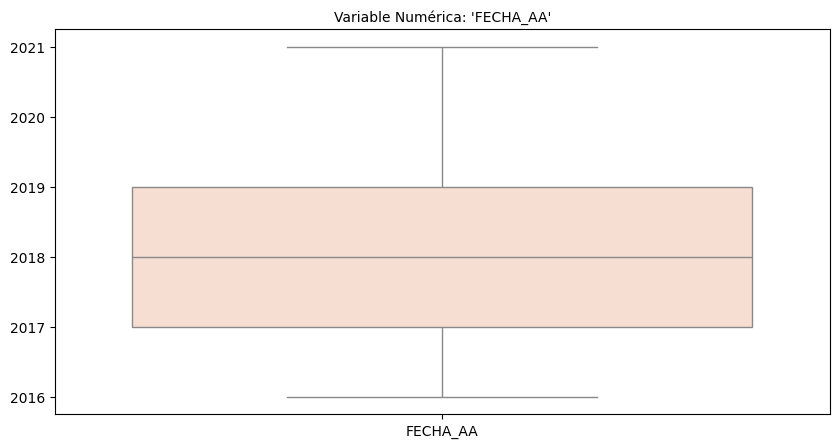

In [32]:
num_cols = ['FECHA_AA']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)
plt.title("Variable Numérica: 'FECHA_AA'", fontsize=10)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\1890744525.py:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)


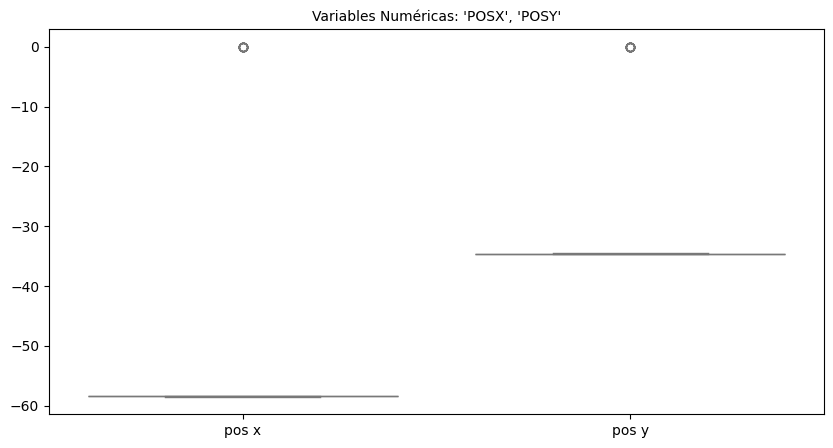

In [33]:
num_cols = ['pos x', 'pos y']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_vhf[num_cols], palette=paleta_siniestros)
plt.title("Variables Numéricas: 'POSX', 'POSY'", fontsize=10)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\3712512232.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_vhf, x=columna, palette=paleta_siniestros)  # Asignar la paleta de colores
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\3712512232.py:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(data=df_vhf, x=columna, palette=paleta_siniestros)  # Asignar la paleta de colores
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7564\3712512232.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_vhf, x=columna, palette=paleta_siniestros)  # Asignar la paleta de colores
C:\Users\Usuario\AppData\Local\Temp\ipy

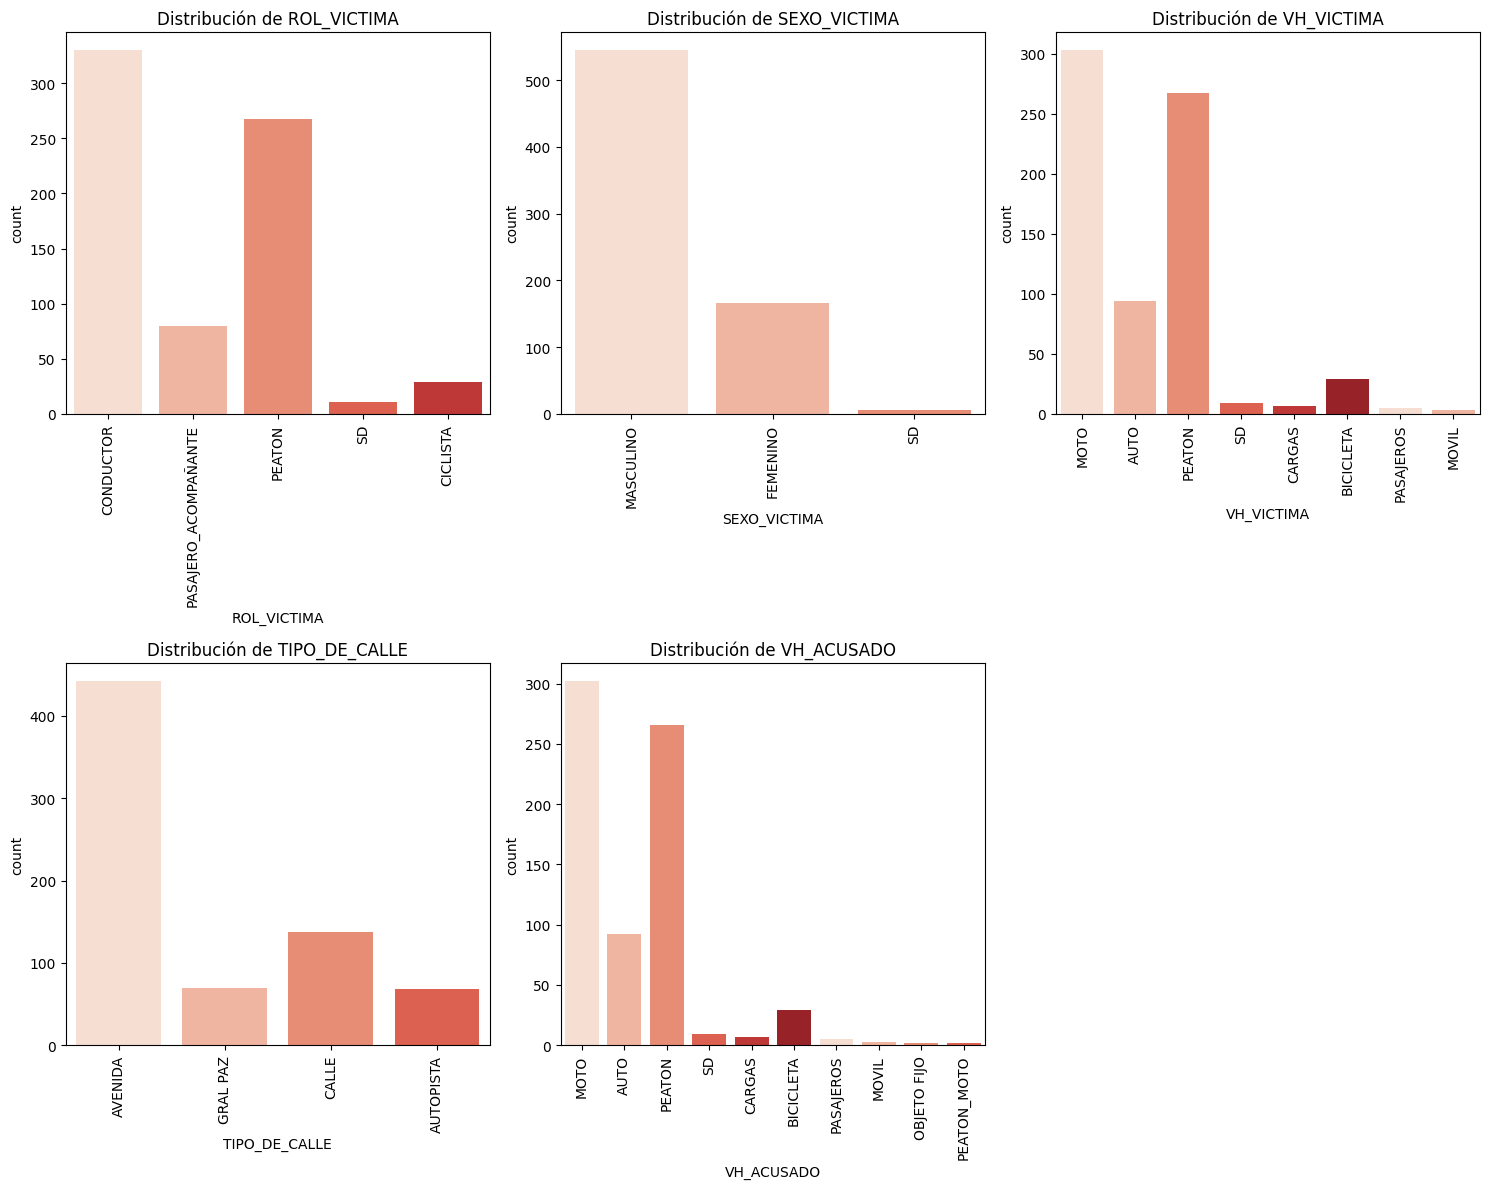

In [35]:
categoricas = ['ROL_VICTIMA', 'SEXO_VICTIMA', 'VH_VICTIMA', 'TIPO_DE_CALLE', 'VH_ACUSADO']

plt.figure(figsize=(15, 12))

for i, columna in enumerate(categoricas, 1):              # ---> Generación de subplots para cada columna categórica
    plt.subplot(2, 3, i)
    sns.countplot(data=df_vhf, x=columna, palette=paleta_siniestros)  # Asignar la paleta de colores
    plt.title(f'Distribución de {columna}')
    plt.xticks(rotation=90)                               # ---> Rotación etiquetas sobre eje x para lograr legibilidad

plt.tight_layout()
plt.show()

# Visualización con histogramas.

In [36]:
df_vhf_cor = df_vhf

le = LabelEncoder()     # ---> Codificación de variables categóricas
df_vhf_cor['FECHA_FALLECIMIENTO'] = le.fit_transform(df_vhf['FECHA_FALLECIMIENTO'])
df_vhf_cor['ROL_VICTIMA'] = le.fit_transform(df_vhf['ROL_VICTIMA'])
df_vhf_cor['SEXO_VICTIMA'] = le.fit_transform(df_vhf['SEXO_VICTIMA'])
df_vhf_cor['VH_VICTIMA'] = le.fit_transform(df_vhf['VH_VICTIMA'])
df_vhf_cor['LUGAR_DEL_HECHO'] = le.fit_transform(df_vhf['LUGAR_DEL_HECHO'])
df_vhf_cor['TIPO_DE_CALLE'] = le.fit_transform(df_vhf['TIPO_DE_CALLE'])
df_vhf_cor['VH_ACUSADO'] = le.fit_transform(df_vhf['VH_ACUSADO'])

In [37]:
df_vhf_cor.describe()

,EDAD_VICTIMA,FECHA_AA,FECHA_DD,FECHA_FALLECIMIENTO,FECHA_MM,ROL_VICTIMA,SEXO_VICTIMA,VH_VICTIMA,COMUNA,HH,LUGAR_DEL_HECHO,pos x,pos y,TIPO_DE_CALLE,VH_ACUSADO
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,39.050209,2018.174338,15.953975,304.336123,6.688982,1.861925,0.776848,3.701534,7.430962,11.538354,340.577406,-57.382053,-33.992006,1.290098,4.128312
std,22.010669,1.672655,8.674876,174.510184,3.575140,1.018907,0.436299,2.109479,4.385067,6.709265,196.828907,7.803187,4.622508,0.767405,2.568665
min,0.000000,2016.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-58.529942,-34.705250,0.000000,0.000000
25%,24.000000,2017.000000,9.000000,152.000000,4.000000,1.000000,1.000000,3.000000,4.000000,6.000000,171.000000,-58.475768,-34.643577,1.000000,3.000000
50%,35.000000,2018.000000,16.000000,304.000000,7.000000,1.000000,1.000000,3.000000,8.000000,11.000000,339.000000,-58.442636,-34.622451,1.000000,3.000000
75%,55.000000,2019.000000,23.000000,461.000000,10.000000,3.000000,1.000000,6.000000,11.000000,17.000000,512.000000,-58.399147,-34.594883,2.000000,7.000000
max,95.000000,2021.000000,31.000000,562.000000,12.000000,4.000000,2.000000,7.000000,15.000000,23.000000,682.000000,0.000000,0.000000,3.000000,9.000000


array([[<Axes: title={'center': 'EDAD_VICTIMA'}>,
        <Axes: title={'center': 'FECHA_AA'}>,
        <Axes: title={'center': 'FECHA_DD'}>,
        <Axes: title={'center': 'FECHA_FALLECIMIENTO'}>],
       [<Axes: title={'center': 'FECHA_MM'}>,
        <Axes: title={'center': 'ROL_VICTIMA'}>,
        <Axes: title={'center': 'SEXO_VICTIMA'}>,
        <Axes: title={'center': 'VH_VICTIMA'}>],
       [<Axes: title={'center': 'COMUNA'}>,
        <Axes: title={'center': 'HH'}>,
        <Axes: title={'center': 'LUGAR_DEL_HECHO'}>,
        <Axes: title={'center': 'pos x'}>],
       [<Axes: title={'center': 'pos y'}>,
        <Axes: title={'center': 'TIPO_DE_CALLE'}>,
        <Axes: title={'center': 'VH_ACUSADO'}>, <Axes: >]], dtype=object)

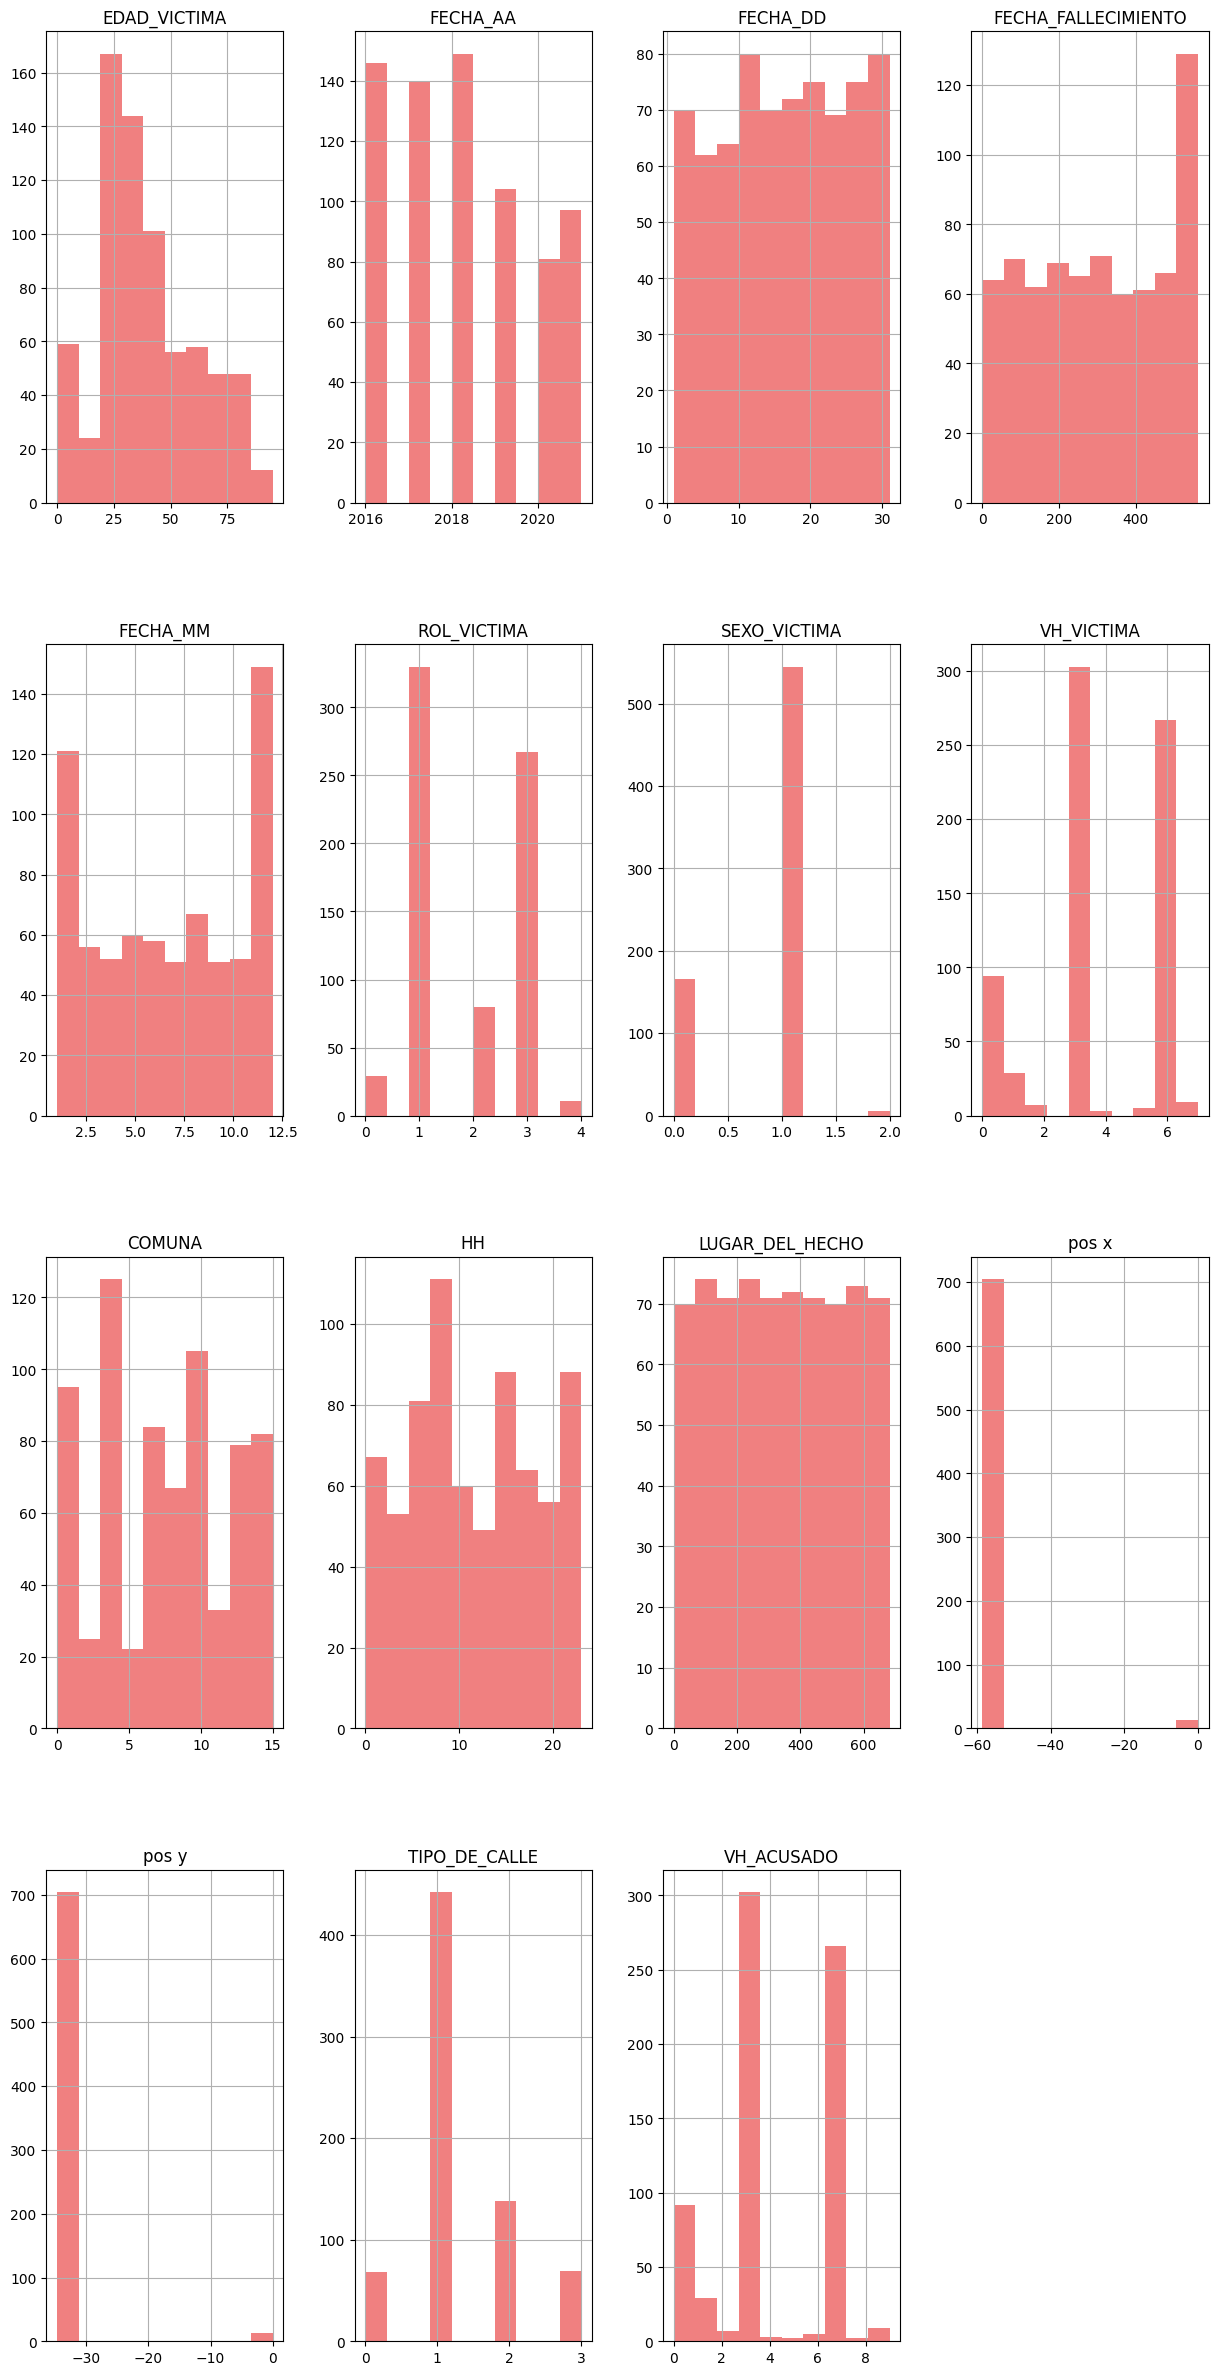

In [38]:
df_vhf_cor.hist(figsize=(15,30), color='lightcoral')

In [39]:
df_vhf_cor.corr()

,EDAD_VICTIMA,FECHA_AA,FECHA_DD,FECHA_FALLECIMIENTO,FECHA_MM,ROL_VICTIMA,SEXO_VICTIMA,VH_VICTIMA,COMUNA,HH,LUGAR_DEL_HECHO,pos x,pos y,TIPO_DE_CALLE,VH_ACUSADO
EDAD_VICTIMA,1.000000,0.097067,-0.009614,-0.030379,0.031134,0.291823,-0.235600,0.259854,-0.047759,0.193356,0.074609,-0.121220,-0.121220,0.023281,0.274482
FECHA_AA,0.097067,1.000000,-0.041702,0.591941,-0.039499,-0.057152,-0.036565,-0.011753,0.017353,-0.045338,0.286497,-0.051621,-0.051239,-0.027487,-0.016266
FECHA_DD,-0.009614,-0.041702,1.000000,0.011008,-0.025906,0.001334,0.028280,-0.020748,-0.000359,-0.018843,0.000377,0.010196,0.010102,0.028233,-0.036088
FECHA_FALLECIMIENTO,-0.030379,0.591941,0.011008,1.000000,0.238409,-0.038855,0.013772,-0.027745,0.048026,0.020728,0.081235,0.026633,0.027177,-0.024945,-0.025748
FECHA_MM,0.031134,-0.039499,-0.025906,0.238409,1.000000,-0.007205,-0.040975,-0.023437,0.058184,0.023177,-0.067234,-0.003270,-0.002800,-0.002193,-0.009488
ROL_VICTIMA,0.291823,-0.057152,0.001334,-0.038855,-0.007205,1.000000,-0.270477,0.810590,-0.063248,0.178010,0.060456,0.018963,0.018674,-0.016576,0.848323
SEXO_VICTIMA,-0.235600,-0.036565,0.028280,0.013772,-0.040975,-0.270477,1.000000,-0.204489,-0.058434,-0.100130,-0.065048,0.165466,0.165050,-0.048323,-0.211197
VH_VICTIMA,0.259854,-0.011753,-0.020748,-0.027745,-0.023437,0.810590,-0.204489,1.000000,-0.056585,0.243863,0.113565,0.005154,0.005129,-0.049107,0.986541
COMUNA,-0.047759,0.017353,-0.000359,0.048026,0.058184,-0.063248,-0.058434,-0.056585,1.000000,-0.040083,0.027880,0.006508,0.013013,0.119265,-0.050050
HH,0.193356,-0.045338,-0.018843,0.020728,0.023177,0.178010,-0.100130,0.243863,-0.040083,1.000000,-0.001977,0.005011,0.004964,-0.047465,0.232626


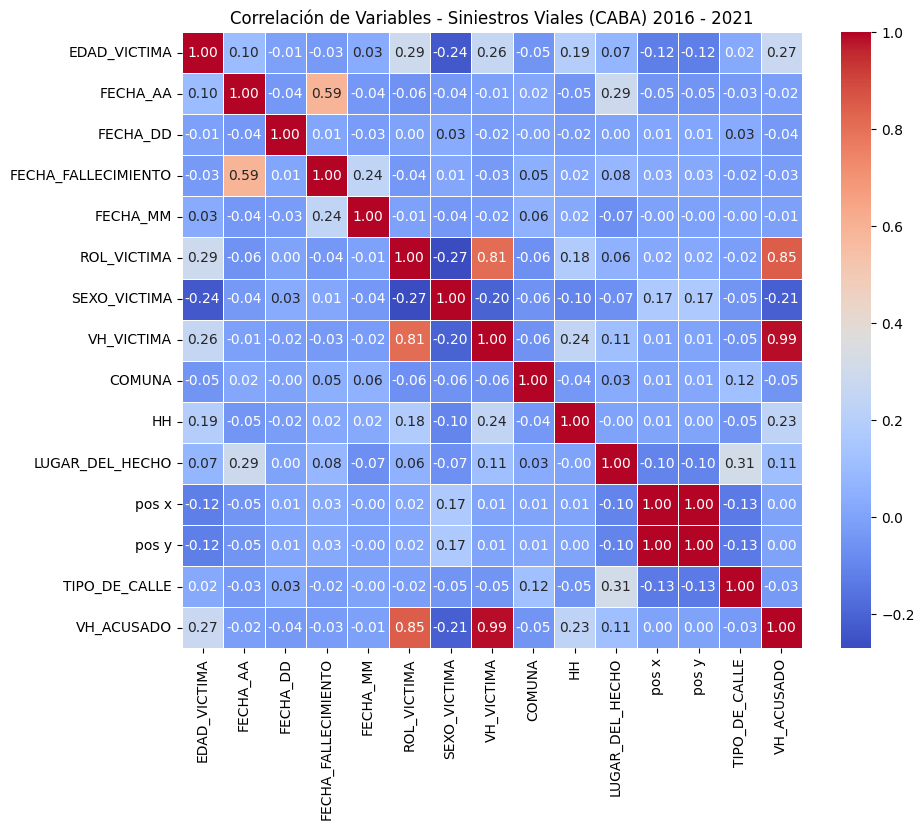

In [41]:
# ---> Asignación de todas las variables de interés para llevar a cabo el análisis correlacional
all_variables = df_vhf_cor[['EDAD_VICTIMA', 'FECHA_AA', 'FECHA_DD', 'FECHA_FALLECIMIENTO', 'FECHA_MM', 'ROL_VICTIMA',
                           'SEXO_VICTIMA', 'VH_VICTIMA', 'COMUNA', 'HH', 'LUGAR_DEL_HECHO', 'pos x', 'pos y', 'TIPO_DE_CALLE', 'VH_ACUSADO']]

matriz_correlacion = all_variables.corr()

# ---> Creación gráfica para visualizar en colores la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación de Variables - Siniestros Viales (CABA) 2016 - 2021')
plt.show()